# Data Preparation:
### Data Preparation it the first step to be performed with the data. This process consists of collecting, cleaning, transforming, and manipulating raw data to make it usable for analysis. 

In [4]:
import pandas as pd
import os
import plotly.express as px
import matplotlib as plt

import warnings

warnings.filterwarnings("ignore")

# Dublin Bikes datasets:
    These datasets were collected from data.gov.ie and they are under License: Creative Commons Attribution 4.0 (CC BY 4.0).
    As a total de 12 file were downloaded, this code will read all files and concatenate into a data frame called dublin_hist.


In [ ]:
path = "./"
files = [file for file in os.listdir(path) if file.startswith('dublinbike-historical-data-2023') ] # filter only historical data files

dublin_hist = pd.DataFrame()

# for loop will load the file in a dataframe "current_month" and concatenate it to the dataframe "dublin_hist".
for file in files:
    current_month = pd.read_csv(path+"/"+file)
    dublin_hist = pd.concat([dublin_hist, current_month])

dublin_hist.shape

### Extracting Station Name and Location for a new dataframe: dublin_bike_stations
    From the dataset, the bike stations will be extracted buy removing duplicates stations from all hist also, unicessary columns will be removed

In [ ]:
dublin_bike_stations = dublin_hist[['STATION ID','NAME','BIKE_STANDS','STATUS','LATITUDE', 'LONGITUDE']].drop_duplicates(subset=["STATION ID"])

dublin_bike_stations.head()

### For proper analysis, only historical data and open station_id will be selected.


In [ ]:
# Filtering only OPEN stations and rename columns.
dublin_hist = dublin_hist[dublin_hist['STATUS'] == 'OPEN']

dublin_hist = dublin_hist[['STATION ID', 'TIME', 'BIKE_STANDS', 'AVAILABLE_BIKE_STANDS', 'AVAILABLE_BIKES']]

#rename column AVAILABLE_BIKE_STANDS to BIKES_IN_USE
dublin_hist.rename(columns={'AVAILABLE_BIKE_STANDS': 'BIKES_IN_USE'}, inplace=True)


# Setting the TIME collumn to datetime
dublin_hist['TIME'] = pd.to_datetime(dublin_hist['TIME'])
dublin_hist.head()

### Calculating the number of trips 

    to get the number of  trips, its is necessary to create a for loop, to filter the dataframe by STATION ID and compare the number of BIKES_IN_USE from current row, to the previous row (diff),  if the number of BIKES_IN_USE is  bigger the previous row, so its a new trip otherwise not

In [ ]:
# create a empty dataframe to receive the cleaned result
bike_usage = pd.DataFrame()

for i in dublin_bike_stations['STATION ID']:
    # filter by STATION ID 
    fitered = dublin_hist[dublin_hist['STATION ID']== i]

    # Sorting by time
    fitered = fitered.sort_values(by=['TIME'], ascending=True)
    
    # creating a new collumn, "TRIPS" and getting the diff of each row
    fitered["TRIPS"] = fitered["BIKES_IN_USE"].diff()
    
    # Concatenat the new bike_usage dataframe with the filtered dataframe (only with trips)
    bike_usage = pd.concat([bike_usage, fitered[fitered['TRIPS']>0]])



bike_usage.head()

# Washington D.C. - Capital BikeShare Datasets
    These datasets were collected from: https://ride.capitalbikeshare.com/system-data and they are under "Capital Bikeshare Data License Agreement"
    As a total de 12 file were downloaded, this code will read all files and concatenate into a data frame called capital_df.



In [ ]:

path = "./"
files = [file for file in os.listdir(path) if file.endswith('capitalbikeshare-tripdata.csv') ] # filter only historical data files

capital_df = pd.DataFrame()

# for loop will load the file in a dataframe "current_month" and concatenate it to the dataframe "capital_df".
for file in files:
    current_month = pd.read_csv(path+"/"+file)
    capital_df = pd.concat([capital_df, current_month])

capital_df.shape

### Cleaning Capital_df dataset

In [ ]:
# Find out if is there any duplicated row and null value

print('duplicated rides:' ,capital_df['ride_id'].duplicated().sum())
print('Null Values: \n',capital_df.isnull().sum())

    Not duplicated rides, but there are some Station_id with null values. Its necessary to fix it


In [ ]:
null_rows = capital_df[capital_df.isnull().any(axis=1)]
null_rows.head(2)


    For this dataset, each row represents one trip, and threre are other columns differente from dublin Bike, as the purpose is to compare both sistems, this dataset will be engineered to became similar to dublin bikeshare dataset.
    As, the purpose of this project is compare the quantity of riders,  the null values will be dropped

In [ ]:
# each row represents one trip
capital_df['TRIPS']=1
capital_df = capital_df.dropna(subset=['start_station_id'])
capital_df['start_station_id'] = capital_df['start_station_id'].astype(int)


# Set the right  type format of column
capital_df['started_at'] = pd.to_datetime(capital_df['started_at'])
capital_df.info(), display(capital_df.head(2));




In [ ]:
### Extracting the Bike Station  location
capital_stations = capital_df[['start_station_id','start_station_name','start_lat','start_lng']].drop_duplicates(subset=["start_station_id"])


# rename the columns name
col_names = {'start_station_id': 'station_id', 'start_station_name': 'station_name', 'start_lat': 'lat','start_lng':'long'}
capital_stations.rename(columns=col_names, inplace=True)
capital_stations.head()

# Reviews Datasets for sentment analysis  -  Dublin Bikes and Capital BikeShare
    For collection of Dublin Bikes and Capital Bikeshare reviews, a tripadvisor API_KEY was created and stored in an .env file.
    Tripeadvisor API allow to request only 5 reviews, which it is not a significant population to perform Machine Learning Sentimental Analysis.
    Due this result a Praw library was used to collect comments from Reddit.
    # "Praw" is an officially supported way to interact with the Reddit API, and Reddit's Terms of Service do allow the use for personal, non-commercial purposes. 

### Function to Collect reviews from TripAdvisor


In [72]:
from dotenv import load_dotenv
from os import getenv
load_dotenv()
import requests
import json

# Function collect_trip collects reviews from tripadvisor, it receives location_id as parameter.
def collect_trip (location_id):
    # Setting Parameters
    api_key = getenv('API_KEY')   
    #location_id = "6439815"   # Dublin Bikes id in TripAdvisor.

    url = f"https://api.tripadvisor.com/api/partner/2.0/location/{location_id}/reviews"

    headers = { "Content-Type": "application/json", "X-TripAdvisor-API-Key": api_key,}

    # This code makes a GET request, If the status code is 200 (Sucess), then it extracts the JSON data from the response and converts it into a pandas DataFrame. 
    # If the status code is not 200, then it prints an error message

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        data = response.json()
        return pd.DataFrame( data['data'])
       
    else:
        return "Error",response.status_code

### Collecting reviews from TripAdvisor for Dublin Bikes

In [73]:
dublin_reviews_df = collect_trip('6439815')

#Select only important features:
dublin_reviews_df = dublin_reviews_df[['title','text']]
dublin_reviews_df

,title,text
0,Dublin not a good place for bicycles,"1. Dublin is a terrible place to ride a bike, ..."
1,Bad service and hidden charges,Avoid at all costs! First we had issues signin...
2,Scam,The actual use of the bike while in Dublin was...
3,No Customer Service,"The bikes themselves are a bit clunky, but the..."
4,Terrible site.,Very bad service. I subscribed for 3 days for ...


### Function to collect comments from Reddit using Praw Library

In [74]:
# First, install praw if its not installed
# !pip install praw
import praw
from datetime import datetime as dt
from dotenv import load_dotenv
from os import getenv


# load .env file
load_dotenv()

# Function collect_reddit: Collects comment from Reddit, it receives the subreddit and the search_query as Paramter, and returns a dataframe
def collect_reddit(subreddit,search_query):
    
    # Initializing Reddit Api
    reddit = praw.Reddit(
    client_id=getenv("APP_ID"), 
    client_secret=getenv("AP_SECRET"), 
    user_agent=f"pda-jmcloudpro u/{getenv('USERNAME')}", 
    )
    
    # Search from subreddit_name
    subreddit = reddit.subreddit(subreddit)

    # Perform a search inside the subreddit
    results = subreddit.search(search_query, limit=500)  

    # Creating Lists to store titles and texts
    titles = []
    texts = []

    # Collect titles and texts
    for submission in results:
        titles.append(submission.title)
        texts.append(submission.selftext)

    
    # Return a DataFrame with title and comments
    return pd.DataFrame({'title': titles, 'text': texts})
    

### Collecting Reddit Comments for Dublin Bikes and adding to dublin_reviews_df
 

In [75]:
dublin = collect_reddit('Dublin','Dublin Bikes')

#Concatenate TripAdvisor Reviews and Reddit Comments.
dublin_reviews_df = pd.concat([dublin_reviews_df,dublin], ignore_index=True)

dublin_reviews_df.head()

,title,text
0,Dublin not a good place for bicycles,"1. Dublin is a terrible place to ride a bike, ..."
1,Bad service and hidden charges,Avoid at all costs! First we had issues signin...
2,Scam,The actual use of the bike while in Dublin was...
3,No Customer Service,"The bikes themselves are a bit clunky, but the..."
4,Terrible site.,Very bad service. I subscribed for 3 days for ...
...,...,...
237,Moving to Dublin in September to go to UCD. Ne...,I am moving to Dublin come September and going...
238,Where should I look to buy?,My boyfriend and I are looking to buy a place ...
239,Cycling vs. Taxis,"Hi,\n\nI recently moved to Dublin and have bee..."
240,Moving to Dublin tomorrow. Which (android) app...,


### Collecting TripAdvisor reviews for Capital BikeShare

In [76]:
capital_reviews_df = collect_trip('2478701')

#Select only important features:
capital_reviews_df = capital_reviews_df[['title','text']]
capital_reviews_df

,title,text
0,"Rideshare, lift E bike",My wife and I were recently in Washington DC a...
1,Ridiculous and ancient method of bike sharing ...,Attempted to have electronic and or regular bi...
2,ABSOLUTELY TERRIBLE COMPANY--CHARGED ME $250 F...,I rented a bike from this company that broke d...
3,Convenient and fun but here are some lessons l...,"So getting around DC on a bike is great, plent..."
4,Walk instead,"Walk, don't bike. Docking stations don't work...."


### Collecting Reddit comments for Capital BikeShare and adding to capital_reviews_df

In [77]:
capital = collect_reddit('washingtondc','Capital Bikeshare')

#Concatenate TripAdvisor Reviews and Reddit Comments.
capital_reviews_df = pd.concat([capital_reviews_df,capital], ignore_index=True)

capital_reviews_df.head()

,title,text
0,"Rideshare, lift E bike",My wife and I were recently in Washington DC a...
1,Ridiculous and ancient method of bike sharing ...,Attempted to have electronic and or regular bi...
2,ABSOLUTELY TERRIBLE COMPANY--CHARGED ME $250 F...,I rented a bike from this company that broke d...
3,Convenient and fun but here are some lessons l...,"So getting around DC on a bike is great, plent..."
4,Walk instead,"Walk, don't bike. Docking stations don't work...."


# Cleaning reviews datasets:

In [78]:
# dublin_reviews_df - Merging title and text
dublin_reviews_df['text'] = dublin_reviews_df['title'] + ' ' + dublin_reviews_df['text']

dublin_reviews_df = dublin_reviews_df.drop(columns=['title'])

# removing any special characters, double spaces, tabs etc.
dublin_reviews_df['text'] = dublin_reviews_df['text'].str.replace('[^\w\s\.]','')


#saving as csv
dublin_reviews_df.to_csv('dublin_reviews_df.csv', index = False)


# Dropping na and duplicates
dublin_reviews_df = dublin_reviews_df.dropna()
dublin_reviews_df = dublin_reviews_df.drop_duplicates()

#saving as csv
dublin_reviews_df.to_csv('dublin_reviews_df.csv', index = False)

dublin_reviews_df.head()

,text
0,Dublin not a good place for bicycles 1. Dublin...
1,Bad service and hidden charges Avoid at all co...
2,Scam The actual use of the bike while in Dubli...
3,No Customer Service The bikes themselves are a...
4,Terrible site. Very bad service. I subscribed ...


In [79]:
# capital_reviews_df - Merging title and text

capital_reviews_df['text'] = capital_reviews_df['title'] + ' ' + capital_reviews_df['text']

capital_reviews_df = capital_reviews_df.drop(columns=['title'])

# removing any special characters, double spaces, tabs etc.
capital_reviews_df['text'] = capital_reviews_df['text'].str.replace('[^\w\s]','')

# Dropping na and duplicates
capital_reviews_df = capital_reviews_df.dropna()
capital_reviews_df = capital_reviews_df.drop_duplicates()


#saving as csv
capital_reviews_df.to_csv('capital_reviews_df.csv', index = False)

capital_reviews_df.head()

,text
0,Rideshare lift E bike My wife and I were recen...
1,Ridiculous and ancient method of bike sharing ...
2,ABSOLUTELY TERRIBLE COMPANYCHARGED ME 250 FOR ...
3,Convenient and fun but here are some lessons l...
4,Walk instead Walk dont bike Docking stations d...


# EDA (Exploratory Data Analysis)  - Understanding the data and patterns

    Showing the top 10 stations with number of trips during the year per Station Name

In [ ]:
import plotly.express as px
trip_by_station_dublin = bike_usage.groupby(['STATION ID'])['TRIPS'].sum().reset_index()                      
trip_by_station_dublin_join = pd.merge(trip_by_station_dublin, dublin_bike_stations, how='inner', on='STATION ID').sort_values(by = 'TRIPS', ascending = False)
top_stations_dublin = trip_by_station_dublin_join.head(10)

fig = px.bar(top_stations_dublin.sort_values(by='TRIPS', ascending = True), 
             x='TRIPS', 
             y='NAME',
             labels=dict(x='TRIPS', y='NAME'),
             title='Top 10 Bike Usage by Station - Dublin',
             hover_data={'BIKE_STANDS': True},
             width=1000, 
             height=500, 
             orientation='h')

# Add annotations for BIKE_STANDS inside the bars
for index, row in top_stations_dublin.iterrows():
    fig.add_annotation(text=str(row['BIKE_STANDS'])+" Bike_Stands",
                       x=row['TRIPS'],
                       y=row['NAME'],
                       xanchor='left',
                       showarrow=False)
fig.update_layout(title_x=0.5)
fig.show()


# Insights:
    The chart suggests that Dublin bikes is most popular in the city center. The busiest stations are all located in or near the city center, and there is a significant drop-off in usage in the suburbs.
    Also, its possible to observe that some stations with fewer bike stands are actually in higher demand than their stand count suggests.




In [ ]:
trip_by_station_capital = capital_df.groupby(['start_station_id'])['TRIPS'].sum().reset_index()
trip_by_station_capital_join = pd.merge(trip_by_station_capital,  capital_stations,  how='inner',  right_on='station_id',  left_on='start_station_id').sort_values(by='TRIPS', ascending=False)

top_10_capital = trip_by_station_capital_join.head(10)

fig = px.bar(top_10_capital.sort_values(by='TRIPS', ascending = True), 
             x='TRIPS', 
             y='station_name',
             labels=dict(x='TRIPS', y='station_name'),
             title='Top 10 Bike Usage by Station - Washington, D.C.',
             width=1000, 
             height=500, 
             orientation='h')

fig.update_layout(title_x=0.5)
fig.show()

In [ ]:
import plotly.express as px
color_mapper = {"OPEN": "#7CFC00", "CLOSED": "#DF0030"}

fig = px.scatter_mapbox(dublin_bike_stations, 
                        lat="LATITUDE",
                        lon="LONGITUDE", 
                        color="STATUS", 
                        size="BIKE_STANDS", 
                        color_discrete_map=color_mapper,
                        size_max=15, 
                        zoom=12, 
                        hover_data=["BIKE_STANDS"],
                        mapbox_style="open-street-map")

# Update layout for larger figure size
fig.update_layout(
    title="Bike Stations in Dublin",
    autosize=False,
    width=1200, 
    height=600,  
)
fig.update_layout(title_x=0.5)

fig.show()

In [ ]:
import plotly.express as px


fig = px.scatter_mapbox(capital_stations, 
                        lat="lat",
                        lon="long", 
                        size_max=15, 
                        zoom=12, 
                        hover_data=["station_name"],
                        mapbox_style="open-street-map")

# Update layout for larger figure size
fig.update_layout(
    title="Bike Stations  - Washington, D.C.",
    autosize=False,
    width=1200, 
    height=600,  
)
fig.update_layout(title_x=0.5)

fig.show()

# Number of trips by weekday and Location
The best approach to perform these chart, is using a dinamic apresentation, and for this purpose, a dashboart using dash and plotly was created

In [ ]:
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input,Output
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go



# Prepare the Plot for Dublin
bike_usage['WEEKDAY'] = bike_usage['TIME'].dt.weekday
dublin_weekady = bike_usage.groupby(['WEEKDAY']).agg(BIKE_STANDS=('BIKE_STANDS', 'sum'), 
                                         TRIPS=('TRIPS', 'sum')).reset_index().sort_values('WEEKDAY', ascending=True)
# reneame the weedkday using a mpa 
dublin_weekady['WEEKDAY'] = dublin_weekady['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})


# Prepare Weekday dataset
capital_df['WEEKDAY'] = capital_df['started_at'].dt.weekday


capital_weekady = capital_df.groupby(['WEEKDAY']).agg(TRIPS=('TRIPS', 'sum')).reset_index().sort_values('WEEKDAY', ascending=True)


# reneame the weedkday using a mpa 
capital_weekady['WEEKDAY'] = capital_weekady['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})


# Build App
app = dash.Dash(__name__)

Location = ['Dublin', "Washington, D.C.",]
app.layout = html.Div([
    html.H1("Trips by WeekDay and Location"),
    dcc.Graph(id='graph'),
    
    # create a dropdown
    html.Label([ "Location",
                
            dcc.RadioItems(
            id='day-dropdown',
            # Select the unique days in dataframe
            value='Dublin', options=[
                {'label': loc, 'value': loc}
                for loc in Location
            ]
        )
    ]),
])


# Define callback to update graph
@app.callback(
     
    Output('graph', 'figure'),
    [Input("day-dropdown", "value")]
    
   
)

# Function to return the chreated chart
def update_figure(Location):
    fig = make_subplots(rows=1, cols=2)
    
    # filter the dataframe    
    if Location == "Dublin":
        return px.bar(dublin_weekady, x='WEEKDAY', y='TRIPS', 
                     labels=dict(x='WEEKDAY', y='TRIPS'),
                     title='Bike Usage by Weekday  - Dublin',
                     width = 600, height = 500)
    else:
        
        # Create Plots
        return px.bar(capital_weekady, x='WEEKDAY', y='TRIPS', 
                             labels=dict(x='WEEKDAY', y='TRIPS'),
                             title='Bike Usage by Weekday - Washington, D.C.',
                             width = 600, height = 500)
        


        
# Run app and display result inline in the notebook
app.run_server(mode='inline')



# Trips by Month and Location

In [ ]:

# Prepare the Plot for Dublin
bike_usage['MONTH'] = bike_usage['TIME'].dt.month
dublin_month = bike_usage.groupby(['MONTH']).agg(TRIPS=('TRIPS', 'sum')).reset_index().sort_values('MONTH', ascending=True)
# reneame the weedkday using a map
dublin_month['MONTH'] = dublin_month['MONTH'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})



# Prepare Weekday dataset
capital_df['MONTH'] = capital_df['started_at'].dt.month


capital_month = capital_df.groupby(['MONTH']).agg(TRIPS=('TRIPS', 'sum')).reset_index().sort_values('MONTH', ascending=True)


# reneame the weedkday using a mpa 
capital_month['MONTH'] = capital_month['MONTH'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})


app = dash.Dash(__name__)


app.layout = html.Div([
    html.H1("Trips by Month and Location"),
    dcc.Graph(id='month'),
    
    # create a dropdown
    html.Label([ "Location",
                
            dcc.RadioItems(
            id='day-dropdown',
            # Select the unique days in dataframe
            value='Dublin', options=[
                {'label': loc, 'value': loc}
                for loc in Location
            ]
        )
    ]),
])


# Define callback to update graph
@app.callback(
     
    Output('month', 'figure'),
    [Input("day-dropdown", "value")]
    
   
)
# Function to return the chreated chart
def update_month(Location):
        
    # filter the dataframe    
    if Location == "Dublin":
        
        return px.bar(dublin_month, x='MONTH', y='TRIPS', 
                     labels=dict(x='MONTH', y='TRIPS'),
                     title='Bike Usage by Month  - Dublin',
                     width = 600, height = 500)
    else:
        
        # Create Plots
        return px.bar(capital_month, x='MONTH', y='TRIPS', 
                             labels=dict(x='MONTH', y='TRIPS'),
                             title='Bike Usage by Month - Washington, D.C.',
                             width = 600, height = 500)
        


# Run app and display result inline in the notebook
app.run_server(mode='inline')

        

### EDA For sentiment Analisys

### Distribution of reviews lenths

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1,2, figsize=(10, 4))

# Calculating the length of each review
dublin_reviews_df['txt_length'] = dublin_reviews_df['text'].apply(len)
capital_reviews_df['txt_length'] = capital_reviews_df['text'].apply(len)

# Plotting the distribution of Dublin review lengths
sns.histplot(dublin_reviews_df['txt_length'], ax=axes[0], bins=25, kde=True,color="Blue")
axes[0].set_title(f'Dist. of reviews Lengths - Dublin - Tot:  {len(dublin_reviews_df)} reviews')




sns.histplot(capital_reviews_df['txt_length'], ax=axes[1],bins=25, kde=True,color="Blue")
axes[1].set_title(f'Dist. of reviews Lengths - Washington, D.C. Tot: {len(capital_reviews_df)} reviews')

# Tighten the layout of the subplots
plt.tight_layout()

    From this Comparison, its possible to observe that there are more loonger reviews for Dublin bikeshare service than for the Washington, D.C. bikeshare service.


### Labeling the reviews using TextBlob

In [ ]:
# if not installed, its necessary to install textblob  
# !pip install textblob   # To install uncoment this line
from textblob import TextBlob

 
# This function: textblob_sentiment_analysis takes a review as input and uses TextBlob to analyze its sentiment.

def textblob_sentiment_analysis(review):
    # Analyzing the sentiment of the review
    sentiment = TextBlob(review).sentiment
    # Classifying based on polarity
    if sentiment.polarity > 0.1:
        return 'Positive'
    elif sentiment.polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'
    
# Applying TextBlob sentiment analysis to the reviews
capital_reviews_df['Sentiment'] = capital_reviews_df['text'].apply(textblob_sentiment_analysis)
dublin_reviews_df['Sentiment'] = dublin_reviews_df['text'].apply(textblob_sentiment_analysis)

   
# Displaying the first few rows with the sentiment
display(capital_reviews_df.head(3))
display(dublin_reviews_df.head(3))

# Comparing the Sentment in both bike Systems.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing the distribution of sentiments
dublin_sentiment = dublin_reviews_df['Sentiment'].value_counts()
capital_sentiment = capital_reviews_df['Sentiment'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Defining custom color palettes
colors = {
    'Negative': "#FF0000",  # Red for Negative sentiment
    'Neutral': "#0000FF",   # Blue for Neutral sentiment
    'Positive': "#00FF00"   # Green for Positive sentiment
}


# Plotting the distribution of sentiments for Dublin
sns.barplot(x=dublin_sentiment.index, y=dublin_sentiment.values, ax=axes[0], palette=colors)
axes[0].set_title('Distribution of Sentiments - Dublin')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')

# Plotting the distribution of sentiments for Capital Bikeshare
sns.barplot(x=capital_sentiment.index, y=capital_sentiment.values, ax=axes[1], palette=colors)
axes[1].set_title('Distribution of Sentiments - Capital Bikeshare')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


# Insight:

    The graphs show that the sentiment for both: Dublin and Washington D.C is  positive. However, there is a small percentage of negative sentiment for both services.
    Also, for Capital Bikeshare, there are more neutral sentiment than positive sentiment.

# 2.0 Statistics for Data Analytics
### Descriptive statistics are a set of tools and techniques used to summarize and describe the key features of a dataset.

### Distribution and Density of Dubin bike_usage Dataframe
    plotting the Distribution of the dataset: “bike_usage”, it represents the bike usage in Dublin Bike System.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot the distributions on the subplots

std_dev = bike_usage["BIKE_STANDS"].std()
mean = bike_usage['BIKE_STANDS'].mean()
sns.distplot(bike_usage['BIKE_STANDS'], ax=axes[0, 0], label='Bike Stands')
axes[0, 0].set_title('Distribution of Bike Stands')
axes[0, 0].axvline(bike_usage['BIKE_STANDS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[0, 0].axvline(bike_usage['BIKE_STANDS'].std(), color='orange', linestyle='--', label= (f'Std: {std_dev}'))
axes[0, 0].legend()



std_dev = bike_usage["BIKES_IN_USE"].std()
mean = bike_usage['BIKES_IN_USE'].mean()                 
sns.distplot(bike_usage['BIKES_IN_USE'], kde=True, ax=axes[0, 1], label='Bikes in Use')
axes[0, 1].set_title('Distribution of Bikes in Use')
axes[0, 1].axvline(bike_usage['BIKES_IN_USE'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[0, 1].axvline(bike_usage['BIKES_IN_USE'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[0, 1].legend()




std_dev = bike_usage["AVAILABLE_BIKES"].std()
mean = bike_usage['AVAILABLE_BIKES'].mean()
sns.distplot(bike_usage['AVAILABLE_BIKES'], kde=True, ax=axes[1, 0], label='Available Bikes')
axes[1, 0].set_title('Distribution of Available Bikes')
axes[1, 0].axvline(bike_usage['AVAILABLE_BIKES'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[1, 0].axvline(bike_usage['AVAILABLE_BIKES'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[1, 0].legend()




std_dev = bike_usage["TRIPS"].std()
mean = bike_usage['TRIPS'].mean()
sns.distplot(bike_usage['TRIPS'], kde=True, ax=axes[1, 1], label='Trips')
axes[1, 1].set_title('Distribution of Trips')
axes[1, 1].axvline(bike_usage['TRIPS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[1, 1].axvline(bike_usage['TRIPS'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[1, 1].legend()

# Tighten the layout of the subplots
plt.tight_layout()

# Insights
    Distribution of Bike Stands by Density

    The chart shows that the majority of bike stands have a density of between 10 and 25 per unit area. 

    However, there is a small number of stations with a significantly higher or lower number of bike stands than the average. 
    This suggests that there may be a need to redistribute bike stands to ensure that all stations have a similar number of bike stands available.


    Distribution of Bikes in Use

    From the Distribution of Bikes in Use, with a mean of 20.65 and a standard deviation of 10.33, its possible assume that the majority of bikes in use have a usage of between 10.33 and 30.97. There is a smaller number of bikes that are used more or less than this range.
    This suggests that bikes are typically used for a variety of purposes, from short commutes to longer recreational rides..

    Distribution of Available Bikes

    From this chart, its observed that the majority of available bikes have a density of between 10 and 20. Also, there are a smaller number of available bikes with densities below 10 or above 20.
    That means, the available bikes are typically concentrated in certain areas, rather than being evenly distributed throughout the area.


    Distribution of Trips

    The distribution of trips is skewed to the right, with a mean of 2.2 and a standard deviation of 2.35. This indicates that there are more times when there are fewer trips than times when there are more trips.

# Distribution and Density of Trips grouped by station on Both Datasets



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# grpouping Cpitaol_DF trips by station_id
capital_grp_trips = capital_df.groupby('start_station_id')['TRIPS'].sum().reset_index()

# grpouping Dublin bike_usage df  by station_id
dublin_grp_trips = bike_usage.groupby('STATION ID')['TRIPS'].sum().reset_index()


fig, axes = plt.subplots(1,2, figsize=(10, 5))


# Plot the distributions on the subplots
std_dev = capital_grp_trips["TRIPS"].std()
mean = capital_grp_trips['TRIPS'].mean()               
sns.distplot(capital_grp_trips['TRIPS'], ax=axes[0], label='Bike Stands')
axes[0].set_title('Distribution of Trips by Station ID  - Capital DF')
axes[0].axvline(capital_grp_trips['TRIPS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[0].axvline(capital_grp_trips['TRIPS'].std(), color='orange', linestyle='--', label= (f'Std: {std_dev}'))
axes[0].legend()


std_dev = dublin_grp_trips["TRIPS"].std()
mean = dublin_grp_trips['TRIPS'].mean()
sns.distplot(dublin_grp_trips['TRIPS'], kde=True, ax=axes[1], label='Trips')
axes[1].set_title('Distribution of Trips by Station ID - Dublin Bikes')
axes[1].axvline(dublin_grp_trips['TRIPS'].mean(), color='red', linestyle='--', label=(f'Mean:{mean}'))
axes[1].axvline(dublin_grp_trips['TRIPS'].std(), color='orange', linestyle='--', label=(f'Std: {std_dev}'))
axes[1].legend()


# Tighten the layout of the subplots
plt.tight_layout()

    Its possible to see in both results that the distribution is positively skewed, showing that there are a few stations with a very high number of trips and others stations with a lower number of trips.
    Also, the mean number of trips per station is higher for Capital DF (5240) than for Dublin Bikes (9197), this indicates that the average station in Capital DF has more trips than Dublin Station.


# Correlation between features in Dublin bike_share dataframe


In [ ]:
import seaborn as sns
# Correlation between Bike Stands and Bikes in Use
corr = bike_usage[['BIKE_STANDS', 'BIKES_IN_USE', 'AVAILABLE_BIKES', 'TRIPS', 'MONTH', 'WEEKDAY']].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")

plt.show()



# From this correlation heatmap, its possigle to observe these insights. 

    There is a strong negative correlation between BIKE_STANDS and BIKES_IN_USE. This means that as the number of bike stands at a station increases, the number of bikes in use at that station decreases. 
    There is a moderate negative correlation between AVAILABLE_BIKES and TRIPS. This means that as the number of available bikes at a station decreases, the number of bike trips starting  from station increases. 
    there is a very weak correlation between MONTH and TRIPS. This suggests that the number of bike trips does not vary significantly throughout the year.

# Frequency distribution of WeekDay - Comparing Dublin Dataset to Capital_Df

### Dublin bike_usage dataset

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt1
plt.figure(figsize=(8, 6))
bike_usage['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}).value_counts().plot(kind='bar')
plt.xlabel('Weekday')
plt.ylabel('Frequency')
plt.title('Frequency distribution of use by Weekday - Dublin Bike Share')

plt.show()

### Capital_df Dataset

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
capital_df['WEEKDAY'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}).value_counts().plot(kind='bar')
plt.xlabel('Weekday')
plt.ylabel('Frequency')
plt.title('Frequency distribution of use by Weekday - Capital_df')
plt.show()

  # Insights from these plots
    The bike usage in Dublin peaks on Thursdays, with a dip on Sundays, whereas n Capital DF, Thursday is also the most popular weekday, but Monday is the least popular, highlighting that there is a different behavior in each city.

# Inferential Statistics 
    Getting the confidence interval for the population proportion of trips per month.
    
    The population proportion of trips per month is a categorical variable, so we can use the chi-squared test to gain insights into the possible population values.



# Calculating tht confidence interval for the population proportion of trips per month on both datasets

### Dublin bike_usage Dataset


In [ ]:
# Import libraries
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))


# Calculate Proportion of Bike Trips for Each Month - Dublin Bike share Dataset
# --------------------------------------------------------------
monthly_trips =  bike_usage[bike_usage['MONTH']!=12].groupby('MONTH')['TRIPS'].sum()
total_trips =  bike_usage['TRIPS'].sum()
proportions = monthly_trips / total_trips

# Calculate Confidence Intervals for Proportions
conf_intervals = proportion_confint(count=monthly_trips, nobs=total_trips, alpha=0.05, method='normal')

# Create a DataFrame to store the results
results = pd.DataFrame()
results['TRIPS'] = monthly_trips
results['Proportion'] = proportions.values
results['Lower CI'] =  conf_intervals[0]
results['Upper CI'] =  conf_intervals[1]
results = results.reset_index()

  
# Plot the proportion vs month and overlay the confidence intervals

ax0.plot(results['MONTH'], results['Proportion'], marker='o', linestyle='-')
ax0.fill_between(results['MONTH'], results['Lower CI'], results['Upper CI'], alpha=0.2)

# Set labels and title
ax0.set_xlabel('MONTH')
ax0.set_ylabel('Proportion of Bike Trips')
ax0.set_title('Proportions and Confidence Intervals Dublin bike_usage dataframe')

# -------------------------------------------- End Dublin Bike Share Dataset

# Calculate Proportion of Bike Trips for Each Month - Capital DF Dataset
monthly_trips =  capital_df.groupby('MONTH')['TRIPS'].sum()
total_trips =  capital_df['TRIPS'].sum()
proportions = monthly_trips / total_trips

# Calculate Confidence Intervals for Proportions
conf_intervals = proportion_confint(count=monthly_trips, nobs=total_trips, alpha=0.05, method='normal')

# Create a DataFrame to store the results
results = pd.DataFrame()
results['TRIPS'] = monthly_trips
results['Proportion'] = proportions.values
results['Lower CI'] =  conf_intervals[0]
results['Upper CI'] =  conf_intervals[1]
results = results.reset_index()

  
# Plot the proportion vs month and overlay the confidence intervals

ax1.plot(results['MONTH'], results['Proportion'], marker='o', linestyle='-')
ax1.fill_between(results['MONTH'], results['Lower CI'], results['Upper CI'], alpha=0.2)

# Set labels and title
ax1.set_xlabel('MONTH')
ax1.set_ylabel('Proportion of Bike Trips')
ax1.set_title('Monthly Bike Trip Proportions and Confidence Intervals Capital_df dataframe')


plt.show()

# Insights:

    The proportion of bike trips in Dublin varies throughout the year, with the highest proportion of trips occurring in June, July, August.The proportion of bike trips in Dublin has been increasing over time, while the proportion of bike trips in Capidal_DF has remained stable.

### Finding similarities between Dublin (bike_usage) and Washington, D.C. (Capital_Df).
    Applying apply parametric and non-parametric inferential statistical techniques(t-test, analysis of variance, Wilcoxon test, chi-squared test, among others).
    
    #For this purpose, its necessary become both datasets similar eacah other.


In [ ]:
capital_df = capital_df[[ 'start_station_id','started_at',  'WEEKDAY', 'MONTH', 'TRIPS'  ]]
bike_usage = bike_usage[[ 'STATION ID', 'TIME', 'WEEKDAY', 'MONTH', 'TRIPS']  ]
display(capital_df.head(2))
display(bike_usage.head(2))

# Sampling
    Sampling data is a fundamental practice in statistics and data analysis. When dealing with large populations,

In [ ]:
import numpy as np
from scipy.stats import ttest_ind, wilcoxon, chi2_contingency, f_oneway, kruskal

# Randomly sample 20% of bike_usage  dataset
bike_usage_sample = bike_usage.sample(frac=0.05, random_state=42) 
bike_usage_sample.reset_index(drop=True, inplace=True)


# Randomly sample 20% of capital_df dataset
capital_df_sample = capital_df.sample(frac=0.05, random_state=42) 
capital_df_sample.reset_index(drop=True, inplace=True)


# Evaluation of the sample size

    Fof validating the sample size, a ECDFs (Empirical Cumulative Distribution Function) was applied in both dataset



In [ ]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y


# ecdf for Dublin bike_usage
d_x_pop, d_y_pop = ecdf(bike_usage['TRIPS'])
d_x_sample, d_y_sample = ecdf(bike_usage_sample['TRIPS'])


# ecdf for Capital DF
c_x_pop, c_y_pop = ecdf(capital_df['TRIPS'])
c_x_sample, c_y_sample = ecdf(capital_df_sample['TRIPS'])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Empirical Cumulative Distribution Function) - bike_usage
ax0.plot(d_x_pop, d_y_pop, marker='.', linestyle='none', color='blue', label='Bike_usage Population')
ax0.plot(d_x_sample, d_y_sample, marker='.', linestyle='none', color='red', label='Bike_usage Sample - 5%')
ax0.set_title('ECDFs (Empirical Cumulative Distribution Function) - bike_usage' )
ax0.legend()


# Plot Empirical Cumulative Distribution Function) - Capital_df
ax1.plot(c_x_pop, c_y_pop, marker='.', linestyle='none', color='green', label='Capital_df Population')
ax1.plot(c_x_sample, c_y_sample, marker='.', linestyle='none', color='yellow', label='Capital_df Sample')
ax1.set_title('ECDFs (Empirical Cumulative Distribution Function) - Capital_df' )
ax1.legend()

plt.show()


    This sample size of dublin bike_usage doesnt represents the population, it should be increased once the population is much larger than the sample.  so It was applied 20%

In [ ]:

import numpy as np
from scipy.stats import ttest_ind, wilcoxon, chi2_contingency, f_oneway, kruskal

# Randomly sample 20% of bike_usage  dataset
bike_usage_sample = bike_usage.sample(frac=0.2, random_state=42) 
bike_usage_sample.reset_index(drop=True, inplace=True)


# Randomly sample 20% of capital_df dataset
capital_df_sample = capital_df.sample(frac=0.2, random_state=42) 
capital_df_sample.reset_index(drop=True, inplace=True)


In [ ]:

# ecdf for Dublin bike_usage
d_x_pop, d_y_pop = ecdf(bike_usage['TRIPS'])
d_x_sample, d_y_sample = ecdf(bike_usage_sample['TRIPS'])


# ecdf for Capital DF
c_x_pop, c_y_pop = ecdf(capital_df['TRIPS'])
c_x_sample, c_y_sample = ecdf(capital_df_sample['TRIPS'])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Empirical Cumulative Distribution Function) - bike_usage
ax0.plot(d_x_pop, d_y_pop, marker='.', linestyle='none', color='blue', label='Bike_usage Population')
ax0.plot(d_x_sample, d_y_sample, marker='.', linestyle='none', color='red', label='Bike_usage Sample - 20%')
ax0.set_title('ECDFs (Empirical Cumulative Distribution Function) - bike_usage' )
ax0.legend()


# Plot Empirical Cumulative Distribution Function) - Capital_df
ax1.plot(c_x_pop, c_y_pop, marker='.', linestyle='none', color='green', label='Capital_df Population')
ax1.plot(c_x_sample, c_y_sample, marker='.', linestyle='none', color='yellow', label='Capital_df Sample')
ax1.set_title('ECDFs (Empirical Cumulative Distribution Function) - Capital_df' )
ax1.legend()

plt.show()

# With 20% the sample now is in a good size.

# Parametric Tests:

    Since the data is about trips at different times and stations, A t-test was applied to compare the means of the trips between Dublin and Washington, D.C.

In [ ]:
# Import necessary libraries
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency

# Parametric Test (t-test)
t_stat, p_val = ttest_ind(bike_usage_sample['TRIPS'], capital_df_sample['TRIPS'])
print(f"T-test: t-statistic = {t_stat}, p-value = {p_val}")

# Conclusion
print("\nConclusions:")
if p_val < 0.05:
    print("There is a significant difference between the two datasets.")
else:
    print("There is no significant difference between the two datasets.")


In [ ]:
# Non-Parametric Test (Wilcoxon)
u_stat, p_val = mannwhitneyu(bike_usage_sample['TRIPS'], capital_df_sample['TRIPS'])
print(f"Wilcoxon test: U-statistic = {u_stat}, p-value = {p_val}")

# Conclusion
print("\nConclusions:")
if p_val < 0.05:
    print("There is a significant difference between the two datasets.")
else:
    print("There is no significant difference between the two datasets.")


In [ ]:
# Chi-Squared Test
# Assuming we want to compare the weekday distribution between the two datasets
contingency_table = pd.crosstab(bike_usage_sample['WEEKDAY'], bike_usage_sample['WEEKDAY'])
chi2, p_val, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Squared Test: Chi2 statistic = {chi2}, p-value = {p_val}")

# Conclusion
print("\nConclusions:")
if p_val < 0.05:
    print("There is a significant difference between the two datasets.")
else:
    print("There is no significant difference between the two datasets.")


### Hypothesis: Comparing Bike Usage in Dublin and Washington D.C. During Daytime
    The hypothesis in question posits that Dublin experiences more bike rides during daytime hours compared to Washington D.C.



In [ ]:
# to test this hypotesis, its necessary to filter the dataframe by hour.
# Subset data for daytime (6 am to 6 pm)
bike_usage_sample['HOUR'] = bike_usage_sample['TIME'].dt.hour
dublin_group  = bike_usage_sample.groupby(['HOUR'])['TRIPS'].sum().reset_index()
capital_df_sample['HOUR'] = capital_df_sample['started_at'].dt.hour
capital_group = capital_df_sample.groupby(['HOUR'])['TRIPS'].sum().reset_index()


dublin_sample_daytime = dublin_group[(dublin_group['HOUR'] >= 6) & (dublin_group['HOUR'] < 18)]
capital_sample_daytime= capital_group[(capital_group['HOUR'] >= 6) & (capital_group['HOUR'] < 18)]


# Calculate total trips for each city during daytime
total_trips_dublin = dublin_sample_daytime['TRIPS'].sum()
total_trips_capital = capital_sample_daytime['TRIPS'].sum()

print(f"Total trips in Dublin during daytime: {total_trips_dublin}")
print(f"Total trips in Washington D.C. during daytime: {total_trips_capital}")

In [ ]:
# Hypothesis Testing (comparing means using t-test)
from scipy import stats

t_stat, p_value = stats.ttest_ind(dublin_sample_daytime['TRIPS'], capital_sample_daytime['TRIPS'], equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: Dublin has more bike usage during daytime than Washington D.C.")
else:
    print("Fail to reject the null hypothesis: No significant difference in bike usage during daytime between Dublin and Washington D.C.")

# Machine Learning

## Utilizing Time Series to Test and Predict bike usage in Dublin bikeshare dataset.


    Filter the dataset to apply in a month (november)
    Also, its necessary to create a series object with time(datetime) as index, and sum of trips.

In [ ]:
import matplotlib.pyplot as plt


bike_usage_filter = bike_usage[bike_usage['TIME'].dt.month == 11]
bike_series = bike_usage_filter.groupby(['TIME'])['TRIPS'].sum()

# Set the size of the data set
plt.figure(figsize = (15, 3))

# Arrange the data set using date_range() method
xticks = pd.date_range(start = bike_series.index.min(), end = bike_series.index.max(), freq = 'D')

# Set the date format for the plot
#plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation = 60, ha = "left")
plt.xticks(xticks, xticks.strftime("%a-%d-%m"), rotation = 60, ha = "left")

plt.plot(bike_series, linewidth = 1)
plt.xlabel("Date")
plt.ylabel("Trips")
plt.show()

### Function to evaluate and plot the prediction, it use the features, target and regressor, also it uses (70%) of data points for training and the rest for testing


In [ ]:
from sklearn.metrics import mean_squared_error


# function to evaluate and plot the prediction, it use the features, target and regressor, also it uses (70%) of data points for training and the rest for testing

def eval_on_features(features, target, regressor):
   
    n_train = round(len(features) * 0.7)
    
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]    
    regressor.fit(X_train, y_train)
       
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    
    # Plotting the chart
    plt.figure(figsize = (15, 3))
    plt.xticks(range(0, len(X), 40), xticks.strftime("%a %m-%d"), rotation = 60, ha = "left")
    plt.plot(range(n_train), y_train, label = "train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label = "test")
    plt.plot(range(n_train), y_pred_train, '--', label = "prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label = "prediction test")
    plt.legend(loc = (1.01, 0))
    plt.title(regressor)
    plt.xlabel("Date")
    plt.ylabel("Trips")
    # End of the chart
    
    
    
    
    # Printting the R^2 and MSE result
    print(f"Model: {regressor}")

    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
        
    mse_test = mean_squared_error(y_test, y_pred)
    print("Test-set MSE: {:.2f}".format(mse_test))
    
    

# Applying RandomForesRegressor over the entire timestamp

In [ ]:

#Extracting the entire timestamp in nanoseconds (POSIX time )
# extract the target values (number of trips)
y = bike_series.values

# convert to POSIX time by dividing by 10**9
X = bike_series.index.astype("int64").values.reshape(-1, 1) // 10**9

from sklearn.ensemble import RandomForestRegressor

# Create an object 'regressor' 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

# Call the function eval_on_features() to predict and calculate the R^2  and the mean_squared_error
eval_on_features(X, y, regressor)

    After Applying this model over the entire timestamp, the result was:
    R-squared value of -0.15 shows that its is not a good model, the model performed poorly and it did not explain the variance in the target variable.
    A MSE of 2395.29 ondicates that,the difference between the predicted number of trips and the actual number of trips is high, it shows a larger discrepancy between predicted and actual values.

# Aplying RandomForesRegressor over the Hour of the day

In [ ]:
# Store the data hourly in X_hour and make one column using reshape(-1, 1)
X_hour = bike_series.index.hour.values.reshape(-1, 1)

# Call the method eval_on_features() to calculate the R^2  and the mean_squared_erroreval_on_features(X_hour, y, regressor)
eval_on_features(X_hour, y, regressor)

    By using the hour of the day as a feature, the RandomForestRegressor model achieved a moderate fit (R^2 of 0.52) and an average prediction error (MSE of 1010.20). which yet is a poor result.

## Applying RandomForesRegressor over the day of the week and the hour of the day

In [ ]:
import numpy as np
# Store the hourly data weekly in X_hour_week and make one column using reshape(-1, 1)
X_day_hour_week = np.hstack([bike_series.index.dayofweek.values.reshape(-1, 1), bike_series.index.hour.values.reshape(-1, 1)])

# Call the method eval_on_features() to calculate the R^2  and the mean_squared_erroreval_on_features(X_hour, y, regressor)
eval_on_features(X_day_hour_week, y, regressor)

    By applying both features, day of the week and hour, model achieved better result, a strong fit (0.80) and a reduced the MSE (408.83).
    What means that taking both factores, the model can provide a better prediction of bike trips

# Applying Linear Regression over the day of the week and the hour of the day

In [ ]:
# import LinearRegression library from sklearn
from sklearn.linear_model import LinearRegression

# Call the method eval_on_features() to calculate the R^2  and the mean_squared_erroreval_on_features(X_hour, y, regressor)
eval_on_features(X_day_hour_week, y, LinearRegression())

    By applying linear regression, the model achieved a bad result, R^2 value of 0.08 and a high prediction error MSE of 2071.39.

### Converting categorical data into numerical representation, applying One-hot encoding.
    

In [ ]:
# import OneHotEncoder from sklearn
from sklearn.preprocessing import OneHotEncoder

# Declare an object (enc) by calling a method OneHotEncoder()
enc = OneHotEncoder()

# Create an array by calling a fit() method
X_day_hour_week_onehot = enc.fit_transform(X_day_hour_week).toarray()



# Using a combination of polynomial features and ridge regression

In [ ]:
# import polynomial library from sklearn
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

# Create and initialise an object named as PolynomialFeatures()
poly_transformer = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)

# Call fit() method to train the model
X_day_hour_week_onehot_poly = poly_transformer.fit_transform(X_day_hour_week_onehot)

# Initialise an object by calling a method Ridge()
lr = Ridge()

# Call a method eval_on_features() to evaluate R^2 and plot 
eval_on_features(X_day_hour_week_onehot_poly, y, lr)

    By transforming the categorical data into numerical using one-hot encoding and incorporating polynomial features in combination with Ridge regression, the model have improved. With R^2 of 0.79 and  MSE value of 463.64. this model performed similar RandomForesRegressor over the day of the week and the hour of the day.

# Conclusion:
    From these 3 models, its possible to observe that RandomForestRegressor model performed better than other two. The Ridge regression, with its regularization and polynomial features performed similar, but slightly behind the RandomForestRegressor. whereas the LinearRegression model performed worse.


# Sentimental Analysis

Sentiment analysis falls under the heading of text classification and is a use case of natural language processing (NLP). Simply described, sentiment analysis includes categorizing a text into several emotions, such as happy or sad, neutral, or happy or sad. Determining the underlying tone, emotion, or sentiment of a document is the ultimate goal of sentiment analysis. Another name for this is opinion mining.

## VADER
VADER (Valence Aware Dictionary and Sentiment Reasoner) is a rule-based sentiment analyzer that has been trained on social media text. Just like Text Blob.

# Understanding VADER

In [24]:
import pandas as pd
import nltk

import warnings
warnings.filterwarnings('ignore') # We can suppress the warnings


In [27]:
# if not installed, its necessary to install vaderSentiment
#!pip install vaderSentiment


# Download the lexicon
nltk.download("vader_lexicon") 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\JoseMariodaCruzCosta\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [31]:
# Import the lexicon 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()
# Example
sentence = "Sentiment Analysis is a good techinique to apply over social media"
result = sent_analyzer.polarity_scores(sentence)
result


{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'compound': 0.4404}



* a positive sentiment, compound ≥ 0.05.
* a negative sentiment, compound ≤ -0.05.
* a neutral sentiment, the compound is between ]-0.05, 0.05[

The previous result shows that the sentence does not have any negative information (neg=0). It has some neutral and positive tones (neu=0.585 and pos=0.244). However, the overall sentiment is positive, because compound > 0.05


In [35]:
# Testing with repeated exclamations and capitalization
sentence = "Sentiment Analysis is a AMAZING techinique to apply over social media!!!"
print(sent_analyzer.polarity_scores(sentence_))

{'neg': 0.0, 'neu': 0.471, 'pos': 0.529, 'compound': 0.8284}


    As you can see from this example, the compound jumped to 0.82, which makes the sentence more positive than the one before, as per the value of the compound.

In [ ]:
# A last example with negative sentiment
negative_sent = "I do HATE those fake news on internet!!😡"
print(sent_analyzer.polarity_scores(negative_sent))

# Applaying VADER on Bikeshare services

In [105]:
#Loading Reviews
dublin_reviews_df = pd.read_csv('dublin_reviews_df.csv')
capital_reviews_df = pd.read_csv('capital_reviews_df.csv')

In [81]:
def format_output(output_dict):
  
  polarity = "neutral"

  if(output_dict['compound'] >= 0.05):
    polarity = "positive"

  elif(output_dict['compound'] <= -0.05):
    polarity = "negative"

  return polarity

# Function sentment analyzes the text abd return a  to 
def sentiment(text):
  
  output_dict =  sent_analyzer.polarity_scores(text)
  return format_output(output_dict)

In [82]:
result = sentiment("capital reviews neutral")
result

'neutral'

In [130]:
# Applygint in the dataset

dublin_reviews_df["vader_prediction"] = dublin_reviews_df["text"].apply(sentiment)

dublin_reviews_df.head()

,text,newtext,removed_stop,new_vader_prediction,vader_prediction
0,Dublin not a good place for bicycles 1. Dublin...,dublin not a good place for bicycles 1. dublin...,dublin good place bicycles 1. dublin terrible ...,positive,positive
1,Bad service and hidden charges Avoid at all co...,bad service and hidden charges avoid at all co...,bad service hidden charges avoid costs first i...,neutral,negative
2,Scam The actual use of the bike while in Dubli...,scam the actual use of the bike while in dubli...,scam actual use bike dublin good however still...,negative,negative
3,No Customer Service The bikes themselves are a...,no customer service the bikes themselves are a...,customer service bikes bit clunky real problem...,positive,positive
4,Terrible site. Very bad service. I subscribed ...,terrible site. very bad service. i subscribed ...,terrible site. bad service. subscribed 3 days ...,negative,negative


In [129]:
# Applygint in the dataset
capital_reviews_df["vader_prediction"] = capital_reviews_df["text"].apply(sentiment)

capital_reviews_df.head()

,text,removed_stop,newtext,new_vader_prediction,vader_prediction
0,Rideshare lift E bike My wife and I were recen...,rideshare lift e bike wife recently washington...,rideshare lift e bike my wife and i were recen...,positive,positive
1,Ridiculous and ancient method of bike sharing ...,ridiculous ancient method bike sharing registr...,ridiculous and ancient method of bike sharing ...,negative,negative
2,ABSOLUTELY TERRIBLE COMPANYCHARGED ME 250 FOR ...,absolutely terrible companycharged 250 bike re...,absolutely terrible companycharged me 250 for ...,negative,negative
3,Convenient and fun but here are some lessons l...,convenient fun lessons learned getting around ...,convenient and fun but here are some lessons l...,positive,positive
4,Walk instead Walk dont bike Docking stations d...,walk instead walk dont bike docking stations d...,walk instead walk dont bike docking stations d...,negative,negative


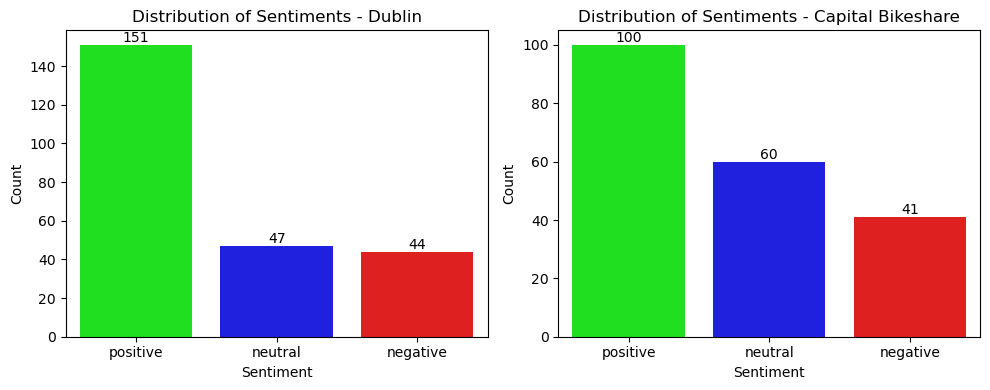

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing the distribution of sentiments
dublin_vader = dublin_reviews_df['vader_prediction'].value_counts()
capital_vader = capital_reviews_df['vader_prediction'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Defining custom color palettes
colors = {
    'negative': "#FF0000",     # Red for Negative sentiment
    'neutral': "#0000FF",      # Blue for Neutral sentiment
    'positive': "#00FF00"   # Green for Positive sentiment
}


# Plotting the distribution of sentiments for Dublin
sns.barplot(x=dublin_vader.index, y=dublin_vader.values, ax=axes[0], palette=colors)
for i, v in enumerate(dublin_vader.values):
    axes[0].text(i, v, v, ha='center', va='bottom')
axes[0].set_title('Distribution of Sentiments - Dublin')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')

# Plotting the distribution of sentiments for Capital Bikeshare
sns.barplot(x=capital_vader.index, y=capital_vader.values, ax=axes[1], palette=colors)
for i, v in enumerate(capital_vader.values):
    axes[1].text(i, v, v, ha='center', va='bottom')
axes[1].set_title('Distribution of Sentiments - Capital Bikeshare')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


    The model seems to be doing a good job because it is much better than a random guess (accuracy = 0.5)! The same observation can be made from the f1-scores of each polarity. Before diving into building machine learning models, it might be better to take VADER as your baseline model for such a task.

# Sentiment Analysis using Bag of Words Vectorization Approach:

    To build a sentiment analysis model using the BOW Vectorization Approach we need a labeled dataset. As stated earlier, the dataset used for this demonstration has been obtained from Kaggle. We have simply used sklearn’s count vectorizer to create the BOW. After, we trained a Multinomial Naive Bayes classifier, for which an accuracy score of 0.84 was obtained.

In [103]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JoseMariodaCruzCosta\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


True

In [138]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

# setting all text in lowercase
capital_reviews_df['newtext'] = capital_reviews_df['text'].apply(lambda x: x.lower())


# Applying stopwords
capital_reviews_df['removed_stop'] = capital_reviews_df['newtext'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

capital_reviews_df[['newtext','removed_stop']].head(2)

 

,newtext,removed_stop
0,rideshare lift e bike my wife and i were recen...,rideshare lift e bike wife recently washington...
1,ridiculous and ancient method of bike sharing ...,ridiculous ancient method bike sharing registr...


In [134]:

# setting all text in lowercase
dublin_reviews_df['newtext'] = dublin_reviews_df['text'].apply(lambda x: x.lower())


# Applying stopwords
dublin_reviews_df['removed_stop'] = dublin_reviews_df['newtext'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

dublin_reviews_df[['newtext','removed_stop']].head(2)

,newtext,removed_stop
0,dublin not a good place for bicycles 1. dublin...,dublin good place bicycles 1. dublin terrible ...
1,bad service and hidden charges avoid at all co...,bad service hidden charges avoid costs first i...


In [135]:
# Applygint VADER after using stop words in the dataset
capital_reviews_df["new_vader_prediction"] = capital_reviews_df["removed_stop"].apply(sentiment)

capital_reviews_df.head(2)

,text,removed_stop,newtext,new_vader_prediction,vader_prediction
0,Rideshare lift E bike My wife and I were recen...,rideshare lift e bike wife recently washington...,rideshare lift e bike my wife and i were recen...,positive,positive
1,Ridiculous and ancient method of bike sharing ...,ridiculous ancient method bike sharing registr...,ridiculous and ancient method of bike sharing ...,negative,negative


In [136]:
dublin_reviews_df["new_vader_prediction"] = dublin_reviews_df["removed_stop"].apply(sentiment)

dublin_reviews_df.head(2)

,text,newtext,removed_stop,new_vader_prediction,vader_prediction
0,Dublin not a good place for bicycles 1. Dublin...,dublin not a good place for bicycles 1. dublin...,dublin good place bicycles 1. dublin terrible ...,positive,positive
1,Bad service and hidden charges Avoid at all co...,bad service and hidden charges avoid at all co...,bad service hidden charges avoid costs first i...,neutral,negative


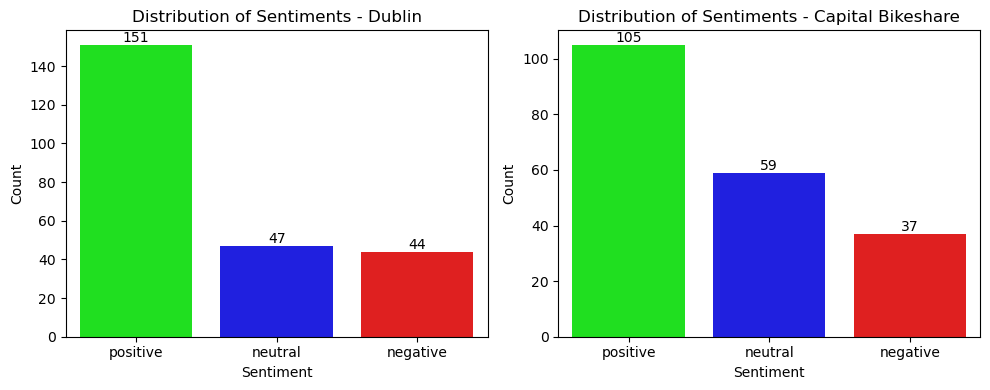

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing the distribution of sentiments
dublin_vader = dublin_reviews_df['new_vader_prediction'].value_counts()
capital_vader = capital_reviews_df['new_vader_prediction'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Defining custom color palettes
colors = {
    'negative': "#FF0000",     # Red for Negative sentiment
    'neutral': "#0000FF",      # Blue for Neutral sentiment
    'positive': "#00FF00"   # Green for Positive sentiment
}


# Plotting the distribution of sentiments for Dublin
sns.barplot(x=dublin_vader.index, y=dublin_vader.values, ax=axes[0], palette=colors)
for i, v in enumerate(dublin_vader.values):
    axes[0].text(i, v, v, ha='center', va='bottom')
axes[0].set_title('Distribution of Sentiments - Dublin')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')

# Plotting the distribution of sentiments for Capital Bikeshare
sns.barplot(x=capital_vader.index, y=capital_vader.values, ax=axes[1], palette=colors)
for i, v in enumerate(capital_vader.values):
    axes[1].text(i, v, v, ha='center', va='bottom')
axes[1].set_title('Distribution of Sentiments - Capital Bikeshare')
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()
